# Описание и цели проекта:

Продуктовая аналитика приложения Procrastinate Pro+. Затраты на привлечение пользователей не окупаются. Провести исследование поведения пользователей за период. Выяснить какие факторы отрицательно влияют на конверсию в покупку. Провести когортный анализ. Рассчитать LTV, ROI, Retention. Оценить окупаемость рекламы.  
**Данные:**  
Логи сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# 1. Загрузка данных. Предварительный анализ.

Импортируем необходимые для работы библиотеки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta
pd.options.display.float_format ='{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

Сохраним предоставленные для анализа данные в соответсвующих переменных.

In [ ]:
visits = pd.read_csv('visits_info.csv')
orders = pd.read_csv('orders_info.csv')
costs = pd.read_csv('costs_info.csv')

Посмотрим на сводную информацию по каждому датасету.

In [ ]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Обратим внимание, что в столбцах с датой тип данных object. Для дальнейшей работы с датой необходимо перевести эти значения в тип datetime. Во всех столбцах одинаковое количество значений - значит пропусков нет. Также заметим, что названия столбцов начинаются с заглавной буквы и в названии столбцов есть пробел - это тоже поправим.

In [ ]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [ ]:
for column in ['region', 'device', 'channel']:
    visits[column] = visits[column].str.lower()

In [ ]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format= '%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format= '%d.%m.%Y %H:%M')

In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Посмотрим есть ли дублирующие строки   

In [ ]:
visits.duplicated().sum()

0

* Теперь посмотрим на данные <strong>orders</strong>

In [ ]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Переименуем стобцы и приведем к нижнему регистру

In [ ]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [ ]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [ ]:
orders.duplicated().sum()

0

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


* Проделаем то же самое для таблицы <strong>costs

In [ ]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [ ]:
costs.columns = costs.columns.str.lower()
costs['channel'] = costs['channel'].str.lower()

In [ ]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null datetime64[ns]
channel    1800 non-null object
costs      1800 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


### Вывод

На этапе предобработки были получены данные для анализа, которые приведены в соответствующие типы. Пропусков и дубликатов не обнаружено. Данные готовы для дальнейшего исследовательского анализа на выявление закономерностей и аномалий.

# 2. Исследовательский анализ данных

Построем профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Также ответим на следующие вопросы:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [ ]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,united states,iphone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,united states,mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,united states,android,tiptop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,united states,mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


Для начала создадим переменную profiles и запишем в ней данные о первых посещениях и других признаках пользователей, которые понадобятся в дальнейшем для анализа.

In [ ]:
profiles = visits.sort_values(['user_id', 'session_start'])\
    .groupby('user_id')\
    .agg({'session_start': 'first', 'channel': 'first', 'region': 'first', 'device': 'first'})\
    .rename(columns={'session_start': 'first_ts'})\
    .reset_index()
    #определяем дату первого посещения
profiles['dt'] = pd.to_datetime(profiles['first_ts'].dt.date)
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    #проверяем есть ли id пользователя в таблице с заказами
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

In [ ]:
profiles.head()

,user_id,first_ts,channel,region,device,dt,month,payer
0,599326,2019-05-07 20:58:00,faceboom,united states,mac,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:00,faceboom,united states,iphone,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:00,organic,france,iphone,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:00,adnonsense,germany,pc,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:00,yrabbit,united states,iphone,2019-10-02,2019-10-01,False


In [ ]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 8 columns):
user_id     150008 non-null int64
first_ts    150008 non-null datetime64[ns]
channel     150008 non-null object
region      150008 non-null object
device      150008 non-null object
dt          150008 non-null datetime64[ns]
month       150008 non-null datetime64[ns]
payer       150008 non-null bool
dtypes: bool(1), datetime64[ns](3), int64(1), object(3)
memory usage: 8.2+ MB


Теперь можно проанализировать какие признаки характерны для первых посещений пользователей. Посмотрим из каких стран приходят больше всего посетители и какая страна больше всех дает платящих пользователей.

Определим минимальную  и максимальную дату привлечения пользователей.

In [ ]:
print('Минимальная дата привлечения: ', profiles['first_ts'].min())
print('Максимальная дата привлечения: ', profiles['first_ts'].max())

Минимальная дата привлечения:  2019-05-01 00:00:00
Максимальная дата привлечения:  2019-10-27 23:59:00


Напишем функцию, которая будет принимать название столбца из датасета profiles и строить график относительно выбранного признака и дополнительно график для пользователей, которые сконвертировлись в оплату.

In [ ]:
def prof_plot(column):
    profiles.groupby(column).agg({'user_id': 'count'}).sort_values('user_id', ascending=False).plot(kind='bar', ax=plt.subplot(1, 2, 1), figsize=(12, 5), grid=True)
    plt.title('Количество новых пользователей по ' + column)
    profiles.query('payer == True').groupby(column).agg({'user_id': 'count'}).sort_values('user_id', ascending=False).plot(kind='bar', ax=plt.subplot(1, 2, 2), figsize=(12, 5), grid=True) 
    plt.title('Количество новых платящих пользователей по ' + column)
    plt.show()
    print()
    print('Доля платящих по признаку ' + column)
    print()
    print(profiles.groupby(column)\
    .agg({'user_id': 'count', 'payer': 'mean'})\
    .rename(columns={'user_id': 'total_amount_user', 'payer': 'share_payer'})\
    .sort_values('share_payer', ascending=False))


Доля платящих по признаку region

               total_amount_user  share_payer
region                                       
united states             100002         0.07
germany                    14981         0.04
uk                         17575         0.04
france                     17450         0.04


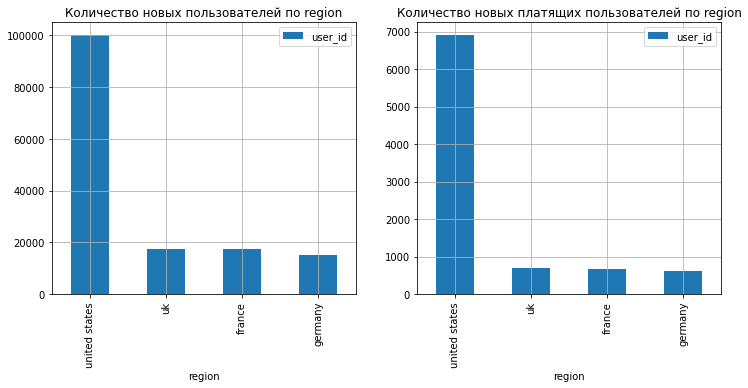

In [ ]:
prof_plot('region')

Соединенные штаты лидируют по количеству привлеченных пользователей, а также по доле платящих пользователей.

* Теперь посмотрим на признак device. Определим каким гаджетом пользуются пользователи и какой из них характерен для платящих пользователей.


Доля платящих по признаку device

         total_amount_user  share_payer
device                                 
mac                  30042         0.06
iphone               54479         0.06
android              35032         0.06
pc                   30455         0.05


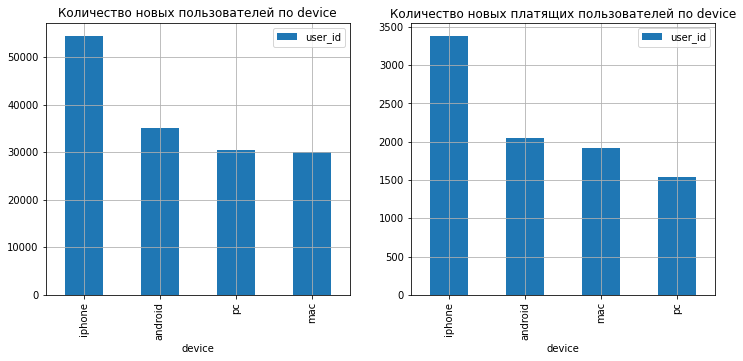

In [ ]:
prof_plot('device')

Пользователей с айфоном больше всех. В целом пользователи ios лучше конвертируются в покупку.


Доля платящих по признаку channel

                    total_amount_user  share_payer
channel                                           
faceboom                        29144         0.12
adnonsense                       3880         0.11
lambdamediaads                   2149         0.10
tiptop                          19561         0.10
rocketsuperads                   4448         0.08
wahoonetbanner                   8553         0.05
yrabbit                          4312         0.04
mediatornado                     4364         0.04
leapbob                          8553         0.03
opplecreativemedia               8605         0.03
organic                         56439         0.02


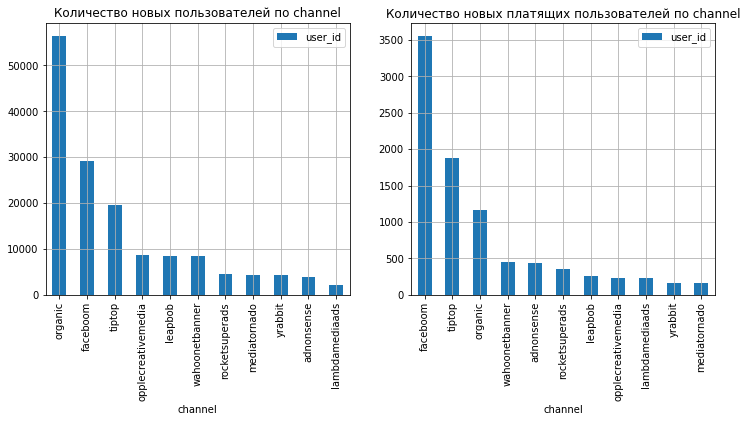

In [ ]:
prof_plot('channel')

Это один из самый важных признаков при оценки эффективности привлечения - откуда приходят новые пользовтели и какой канал лучше всех конвертирует в платящего. Из графиков понятно, что канал с загодчным названием faceboom является наиболее успешным для привлечения пользователей, готовых тратить деньги. Но это очевидный факт, видно, что на него тратили самое большое количество денег.

### Вывод

- США дает значительное количество пользователей и лидирует по доле платящих.
- iphone лидирует по количеству пользователей с устройствами этого производителя.
- faceboom привлекает самое большое количество платящих пользователей.

# 3. Рассчет продуктовых метрик
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

Чтобы ответить на этот вопрос нам понадобятся данные о пользовательских сессиях visits. Выделим из столбца session_start месяц, неделю и день в которые пользователи заходили в приложение.

In [ ]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,united states,iphone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,united states,mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,united states,android,tiptop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,united states,mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


In [ ]:
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_day'] = visits['session_start'].dt.date

- Теперь посчитаем метрики DAU, WAU, MAU. Посчитаем среднее, а также визуализируем, как менялось значение метрики во времени.


Среднее количество пользователей в session_day:
1684

Среднее количество пользователей в session_week:
8353

Среднее количество пользователей в session_month:
28989


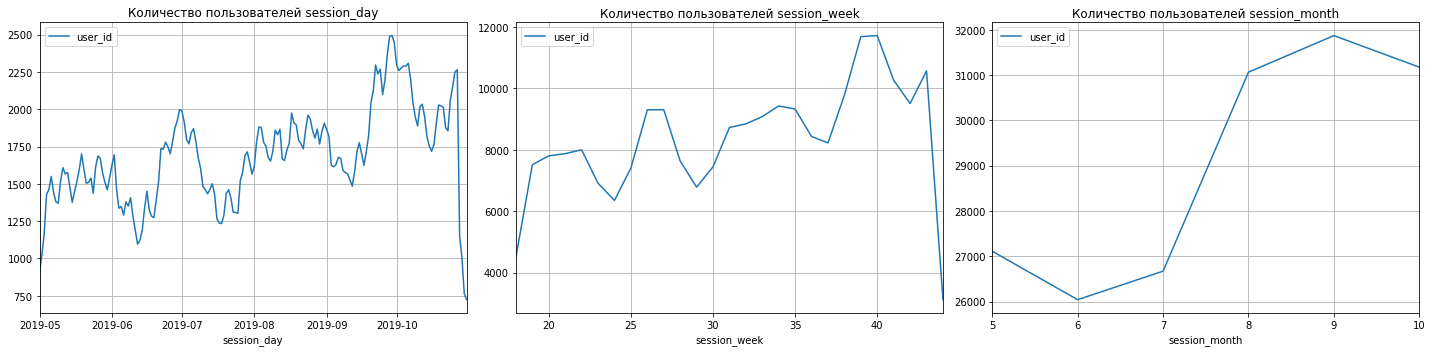

In [ ]:
for i, column in enumerate(['session_day', 'session_week', 'session_month']):
    visits.groupby(column).agg({'user_id': 'nunique'}).plot(ax=plt.subplot(1, 3, i+1), figsize=(20, 5), grid=True)
    plt.title('Количество пользователей ' + column)
    print()
    print('Среднее количество пользователей в ' + column +':')
    print(int(visits.groupby(column).agg({'user_id': 'nunique'}).mean()))
plt.tight_layout()
plt.show()

-    Посмотрим как часто юзеры используют приложение. Построим гисторгамму распределения общего числа сессий в день. А также найдем среднее количество сессий в день.


Среднее количество сессий в день
1684


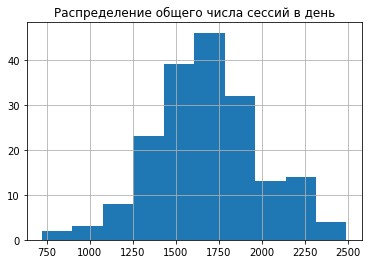

In [ ]:
visits.groupby('session_day')['user_id'].count().hist()
plt.title('Распределение общего числа сессий в день')
plt.show()
print()
print('Среднее количество сессий в день')
print(int(visits.groupby('session_day')['user_id'].count().mean()))

-    Сколько длится одна сессия?

Посчитаем среднюю продолжительность одной сессии.

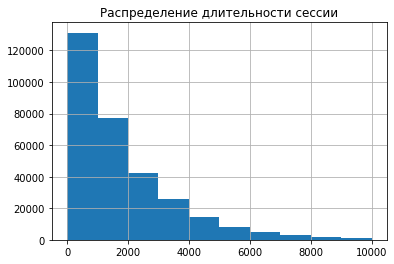

In [ ]:
visits['duration_seconds'] = (visits['session_end'] - visits['session_start']).dt.seconds
visits['duration_seconds'].hist(range=(0, 10000))
plt.title('Распределение длительности сессии')
plt.show()

In [ ]:
visits['duration_seconds'].describe()

count   309,901.00
mean      1,800.08
std       1,803.19
min           0.00
25%         540.00
50%       1,260.00
75%       2,520.00
max      22,260.00
Name: duration_seconds, dtype: float64

Характерное распределение Пуассона: высокий пик в начале и длинный хвост. Так как в наборе данных присутствует большое количество выбросов, то среднее значение брать некорректно. Логичнее будет ориентироваться по медиане, которая составляем 1260 сек или 21 минута. Неплохой показатель.

### Продажи:

- Когда люди начинают покупать? Соединим данные профилей пользователей и их покупок. Посмотрим сколько в среднем проходит время с первого визита до первой покупки в секундах.

Сначала выделим из данных orders первые покупки пользователей. 

In [ ]:
orders_first = orders.sort_values(['user_id', 'event_dt']).groupby('user_id')\
.agg({'event_dt': 'first', 'revenue': 'first'})\
.rename(columns={'event_dt': 'date_first_order'})\
.reset_index()
orders_first.head()

,user_id,date_first_order,revenue
0,599326,2019-05-07 20:59:09,4.99
1,46006712,2019-06-30 03:46:52,4.99
2,374052872,2019-08-16 07:44:47,4.99
3,414791703,2019-05-04 18:06:41,4.99
4,785077127,2019-06-30 18:35:15,4.99


Проведем объединение таблиц методом merge. Оставим в таблице только тех пользователей, которые совершили хотя бы одну покупку.

In [ ]:
duration_first_order = profiles.merge(orders_first, how='inner', on='user_id')
duration_first_order.head()

,user_id,first_ts,channel,region,device,dt,month,payer,date_first_order,revenue
0,599326,2019-05-07 20:58:00,faceboom,united states,mac,2019-05-07,2019-05-01,True,2019-05-07 20:59:09,4.99
1,46006712,2019-06-30 03:46:00,adnonsense,france,android,2019-06-30,2019-06-01,True,2019-06-30 03:46:52,4.99
2,374052872,2019-08-08 15:42:00,tiptop,united states,mac,2019-08-08,2019-08-01,True,2019-08-16 07:44:47,4.99
3,414791703,2019-05-03 12:01:00,tiptop,united states,iphone,2019-05-03,2019-05-01,True,2019-05-04 18:06:41,4.99
4,785077127,2019-06-27 08:31:00,tiptop,united states,mac,2019-06-27,2019-06-01,True,2019-06-30 18:35:15,4.99


Теперь посчитаем сколько времени проходит от первого посещения до первой покупки в минутах.

In [ ]:
duration_first_order['first_order_min'] = (duration_first_order['date_first_order'] - duration_first_order['first_ts']).dt.total_seconds() / 60

Text(0.5, 1.0, 'Диграмма распределения времени до первой покупки в мин')

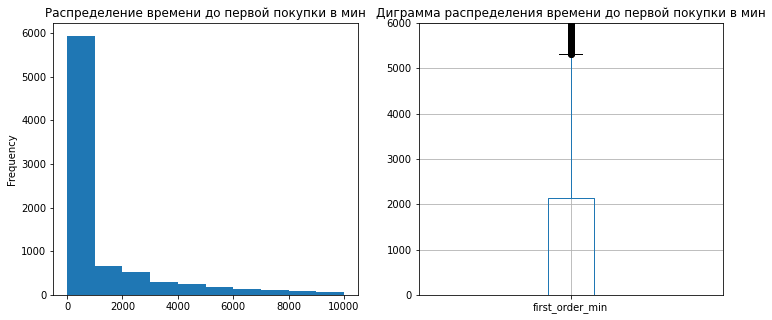

In [ ]:
duration_first_order['first_order_min'].plot(kind='hist', range=(0, 10000), ax=plt.subplot(1, 2, 1), figsize=(12, 5))
plt.title('Распределение времени до первой покупки в мин')
duration_first_order.boxplot('first_order_min', ax=plt.subplot(1,2,2), figsize=(12, 5))
plt.ylim(0, 6000)
plt.title('Диграмма распределения времени до первой покупки в мин')

In [ ]:
duration_first_order['first_order_min'].describe()

count     8,881.00
mean      2,711.84
std       8,692.34
min           0.00
25%           0.68
50%           1.17
75%       2,128.87
max     190,314.92
Name: first_order_min, dtype: float64

Характерное распределение Пуассона. Больше половины значений приходится на покупки сделанные в течении 1 мин 30 сек с момента первого посещения. Но длинный хвост значений простирается вплоть до 5000 мин нормальных значений.

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

In [ ]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Сначала выделим месяц, неделю и дату из даты заказа.

In [ ]:
orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.week
orders['event_date'] = orders['event_dt'].dt.date

Найдем среднее количество покупок на одного пользователя. Посмотрим как это значения меняется во времени.


Среднее количество заказов в event_month
2.182232593476963

Среднее количество заказов в event_week
1.3062205619619944

Среднее количество заказов в event_date
1.0000497388709277


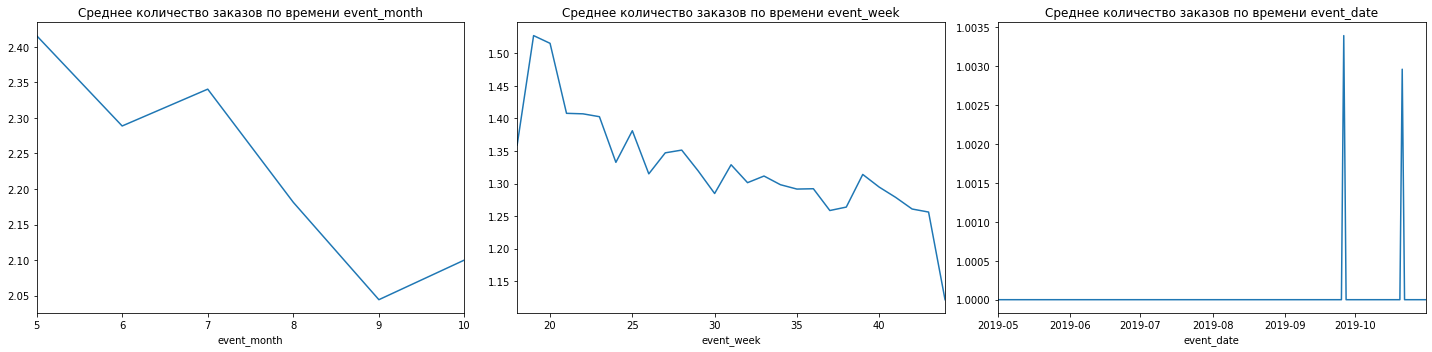

In [ ]:
for i, column in enumerate(['event_month', 'event_week', 'event_date']):
    amount_order = orders.groupby(['user_id', column]).agg({'revenue': 'count'}).rename(columns={'revenue': 'amount_order'}).reset_index()
    amount_order.groupby(column)['amount_order'].mean().plot(ax=plt.subplot(1, 3, i+1), figsize=(20, 5))
    plt.title('Среднее количество заказов по времени ' + column)
    print()
    print('Среднее количество заказов в ' + column)
    print(amount_order['amount_order'].mean())
plt.tight_layout()
plt.show()

- Какой средний чек за месяц, неделю, день?


Средний чек в event_month
revenue   5.37
dtype: float64

Средний чек в event_week
revenue   5.38
dtype: float64

Средний чек в event_date
revenue   5.38
dtype: float64


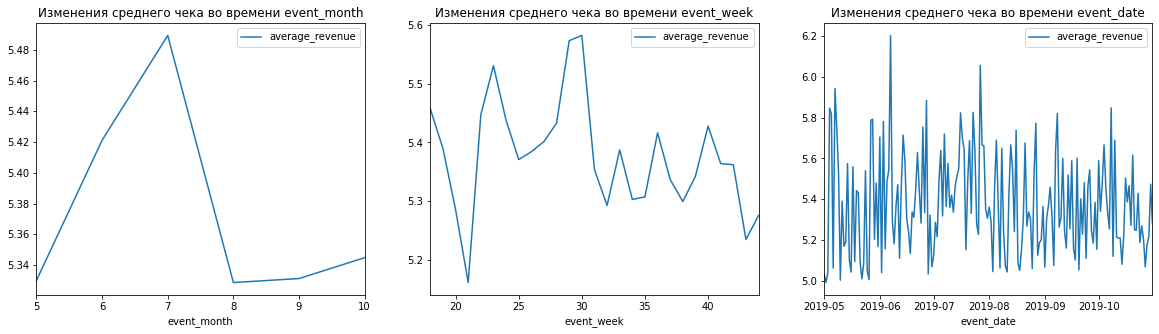

In [ ]:
for i, column in enumerate(['event_month', 'event_week', 'event_date']):
    orders.groupby(column).agg({'revenue': 'mean'}).rename(columns={'revenue': 'average_revenue'}).plot(ax=plt.subplot(1, 3, i+1), figsize=(20, 5))
    plt.title('Изменения среднего чека во времени ' + column)
    print()
    print('Средний чек в ' + column)
    print(orders.groupby(column).agg({'revenue': 'mean'}).mean())

Изменения среднего чека незначительные. 

### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

In [ ]:
costs.head()

,dt,channel,costs
0,2019-05-01,faceboom,113.30
1,2019-05-02,faceboom,78.10
2,2019-05-03,faceboom,85.80
3,2019-05-04,faceboom,136.40
4,2019-05-05,faceboom,122.10


Посчитаем общую сумму расходов на маркетинг.

In [ ]:
costs['costs'].sum()

105497.30000000002

Посчитаем общую сумму выручки.

In [ ]:
orders['revenue'].sum()

215962.88

Теперь посмотрим на какие каналы потратили больше всего денег. И соединим ее с таблицей о привлеченных клиентах.

In [ ]:
costs_channel = costs.groupby('channel').agg({'costs': 'sum'}).rename(columns={'costs': 'total_costs'})
profiles_of_channel = profiles.groupby('channel')\
    .agg({'user_id': 'count', 'payer': 'mean'})\
    .rename(columns={'user_id': 'total_amount_user', 'payer': 'share_payer'})\
    .sort_values('share_payer', ascending=False)
cac_channel = profiles_of_channel.join(costs_channel).sort_values('total_costs', ascending=False)
cac_channel

,total_amount_user,share_payer,total_costs
channel,,,
tiptop,19561,0.10,"54,751.30"
faceboom,29144,0.12,"32,445.60"
wahoonetbanner,8553,0.05,"5,151.00"
adnonsense,3880,0.11,"3,911.25"
opplecreativemedia,8605,0.03,"2,151.25"
rocketsuperads,4448,0.08,"1,833.00"
leapbob,8553,0.03,"1,797.60"
lambdamediaads,2149,0.10,"1,557.60"
mediatornado,4364,0.04,954.48


Таблица хорошая показывает куда уходили деньги и сколько клиентов пришло из этого канала. Как видим не самое удачное распределение рекламного бюджета. Канал tiptop на вложенные 54 751 пришло 19561 клиент, так себе результат в сравнении с каналом faceboom и adnonsense.

Построим график изменения затрат на рекламу в течении времени.

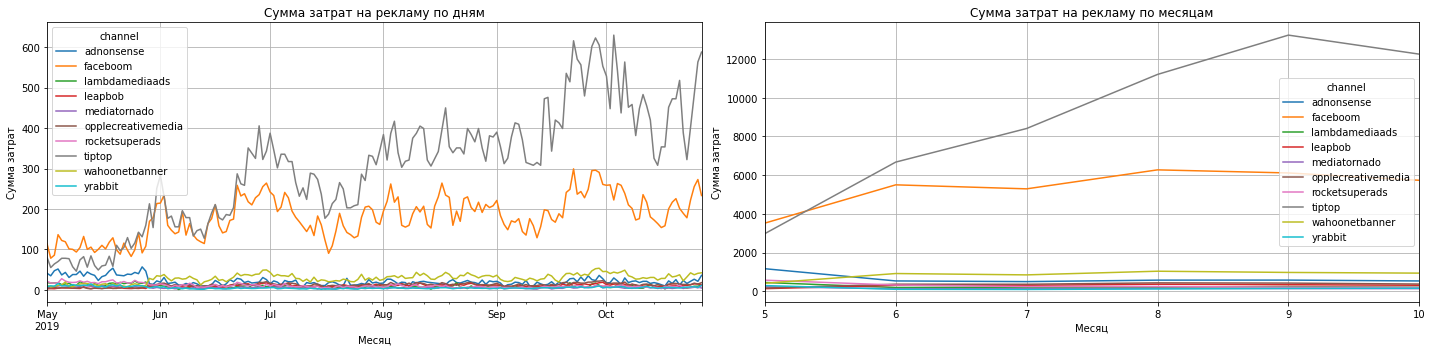

In [ ]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(20,5), ax=plt.subplot(1,2,1))
plt.title('Сумма затрат на рекламу по дням')
plt.xlabel('Месяц')
plt.ylabel('Сумма затрат')
costs['month'] = costs['dt'].dt.month
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(20,5), ax=plt.subplot(1,2,2))
plt.title('Сумма затрат на рекламу по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма затрат')
plt.tight_layout()

График показывает как распределяли рекламный бюджет в течении времени. Видим, что затраты на канал tiptop идут вверх вплоть до сентября, в то время, как на другие канали расходы примерно постоянны во времени. 

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

Ранее мы составили таблицу cac_channel в которой объединили данные о том сколько пользователей пришло из разных каналов с рекламными затратами на привлечение в соответствующем канале. Теперь посчитаем сколько стоит привлечение 1-го пользователя в каждом канале. 

Уберем из нашей таблицы канал organic, т.к на этот канал не затрачивали рекламный бюджет.

In [ ]:
cac_channel= cac_channel.drop('organic')
cac_channel['cac'] = cac_channel['total_costs'] / cac_channel['total_amount_user']
cac_channel

,total_amount_user,share_payer,total_costs,cac
channel,,,,
tiptop,19561,0.10,"54,751.30",2.80
faceboom,29144,0.12,"32,445.60",1.11
wahoonetbanner,8553,0.05,"5,151.00",0.60
adnonsense,3880,0.11,"3,911.25",1.01
opplecreativemedia,8605,0.03,"2,151.25",0.25
rocketsuperads,4448,0.08,"1,833.00",0.41
leapbob,8553,0.03,"1,797.60",0.21
lambdamediaads,2149,0.10,"1,557.60",0.72
mediatornado,4364,0.04,954.48,0.22


Как видим стоимость привлечения в канале tiptop составляет 2.80, что больше чем в 2 раза превышает стоимость привлечения в faceboom. Посмотрим на общую стоимость привлечения пользователя.

In [ ]:
print('Стоимость привлечения пользователя по всем каналам привлечения:')
cac_channel['total_costs'].sum() / cac_channel['total_amount_user'].sum()

Стоимость привлечения пользователя по всем каналам привлечения:


1.1274813239427592

# Расчет и анализа LTV, ROI, удержания и конверсий


* Функция для построения профиля пользователей со столбцов стоимостью привлечения.

In [ ]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles(profiles, orders, ad_costs):
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [ ]:
profiles = get_profiles(profiles, orders, costs)

In [ ]:
profiles.head()

,user_id,first_ts,channel,region,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,faceboom,united states,mac,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:00,faceboom,united states,iphone,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:00,organic,france,iphone,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:00,adnonsense,germany,pc,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:00,yrabbit,united states,iphone,2019-10-02,2019-10-01,False,0.23


* Функция для расчета retention rate:

In [ ]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

* Функция для расчета конверсии CR:  

In [ ]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

* Функция для расчета LTV 

In [ ]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

<strong> Функции для построения графиков </strong>

Функция для сглаживания кривых.

In [ ]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

* Функция для построения графиков удержания пользователей.

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()



Построение графиков для конверсии.

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации пожизненной ценности клиента и окупаемости.

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

* Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Органических пользователей в анализ не включаем, т.к нам нужно оценить эффективность платных каналов.

Зададим момент и горизонт анализа.

In [ ]:
observation_date = datetime(2019, 10, 27).date()
horizon_days = 14

### Общая окупаемость рекламы

Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=[]
)

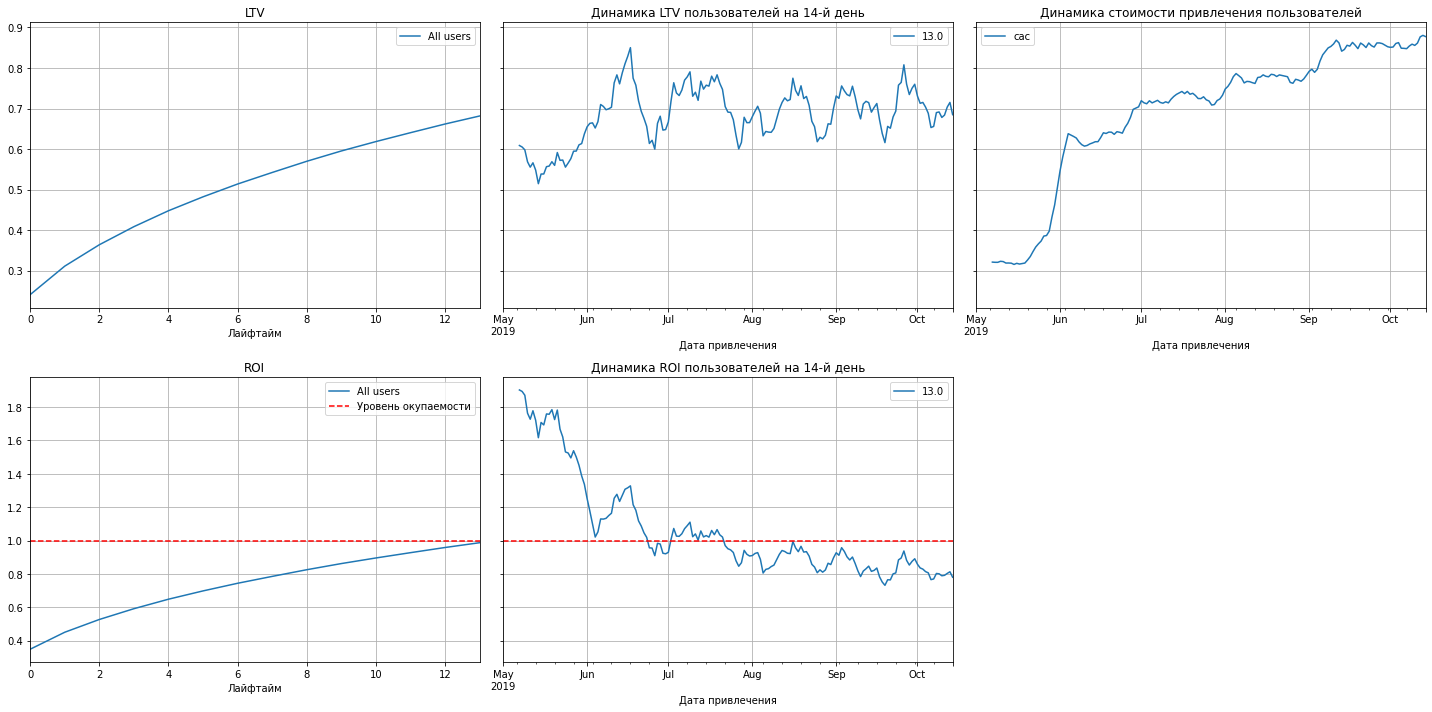

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

По графикам можно сделать следующие выводы:
- Реклама не окупается с конца июля и сохраняется тренд на снижение ROI и увеличения стоимости привлечения клинета.
- Стоимость привлечения клиента CAC постоянно растет во времени, что говорит о увеличении рекламного бюджета со временем и выбора наиболее дорогих каналов привлечения.
- LTV имеет небольшой скачок прироста с июня по июль, далее этот показатель достаточно стабилен и колеблется от 0,6 до 0,8. Значит привлекаемые пользователи в целом попадают в целевую аудиторию.

### Окупаемость рекламы с разбивкой по устройствам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

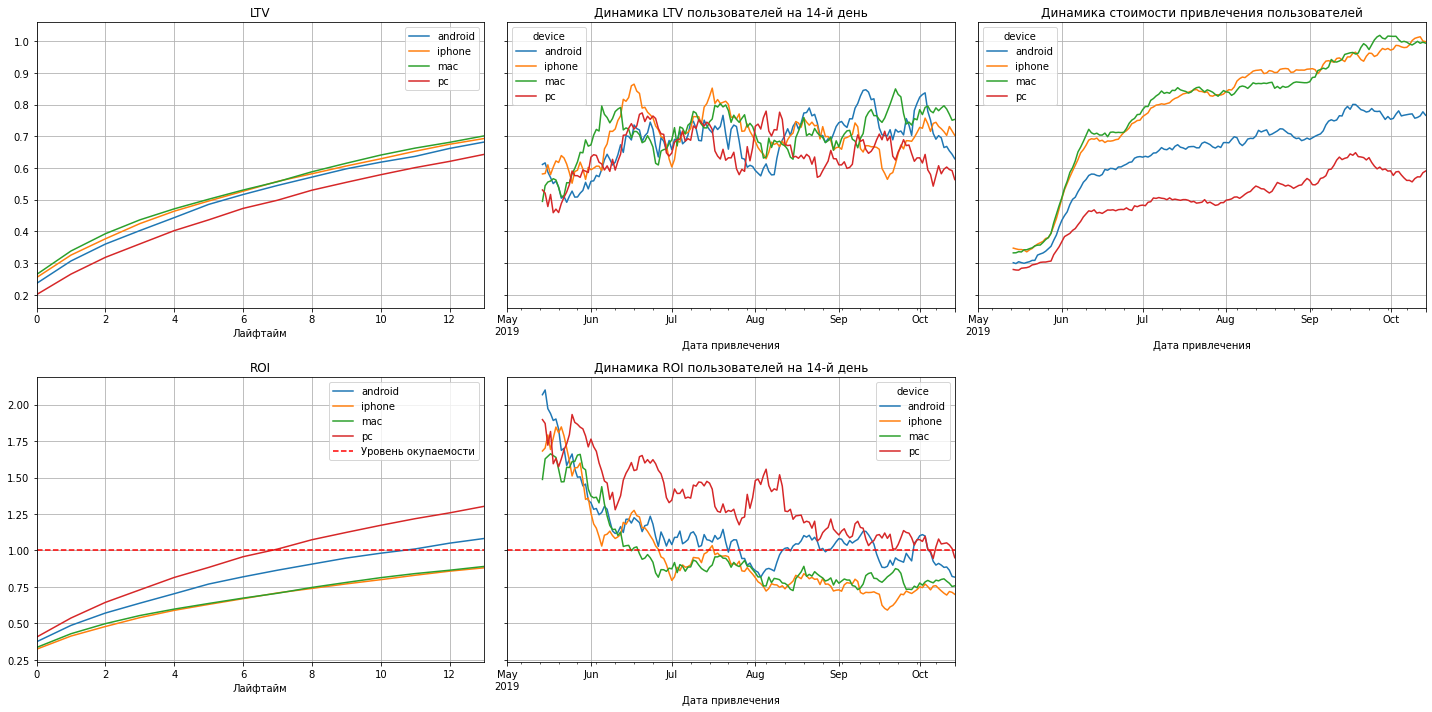

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

По графикам можно сделать следующие выводы:
- Все девайсы имеют схожие тренды поведения LTV, CAC, ROI
- Стоит отметить разницу в стоиомсти привлечения CAC для устройств Apple (mac, iphone) и Android и PC. Последние имеют схожий по абсолютным значениям LTV, но гораздо меньше стоиомсть привлечения CAC, что позволяло выходить в плюс и окупать рекламные вложения в пользователей этих устройств. 
- Высокая стоимость привлечения клиента для устройств iphone и mac не позволяет при таком LTV окупить рекламу. Вывод один напрашивается сам собой - менять канали привлечения и снижать CAC.

### Окупаемость рекламы с разбивкой по странам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

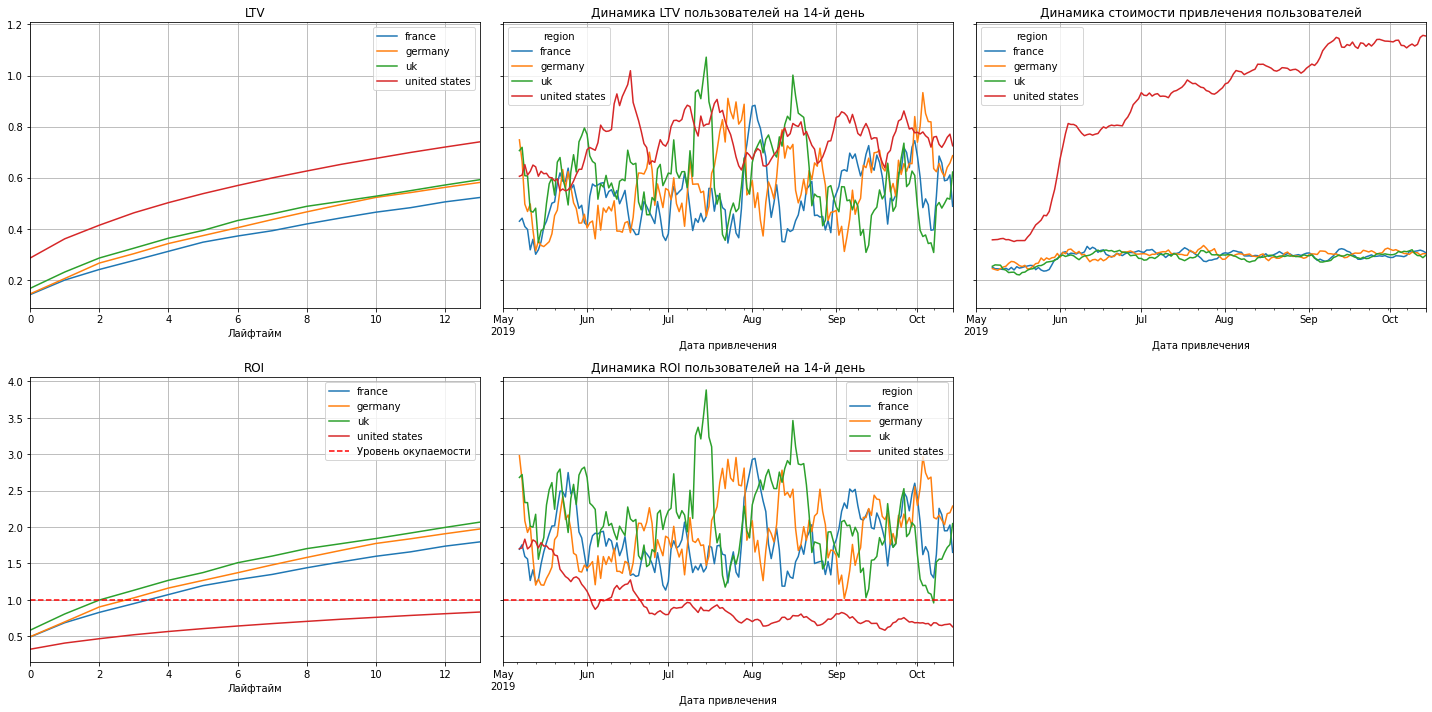

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

По графикам можно сделать следующие выводы:
- США является основным регионом по привлечению клиентов. Как мы видили ранее количество привлеченных пользователей из США состовляют большую часть.
- Усредненно LTV в США больше, чем в других странах. Но стоиомость привлечения в США в несколько раз выше чем в других странах, что не позволяет окупить вложенные средства.
- Как видим из графика динамики ROI все страны, кроме США окупают свои вложения и стоиомсть привлечения остается постоянной во времени в отличии от Соединенных Штатов, где с конца июня по конец октября реклама не окупалась и стоимость привлечения увеличивалась на всем временном промежутке.

### Окупаемость рекламы с разбивкой по рекламным каналам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

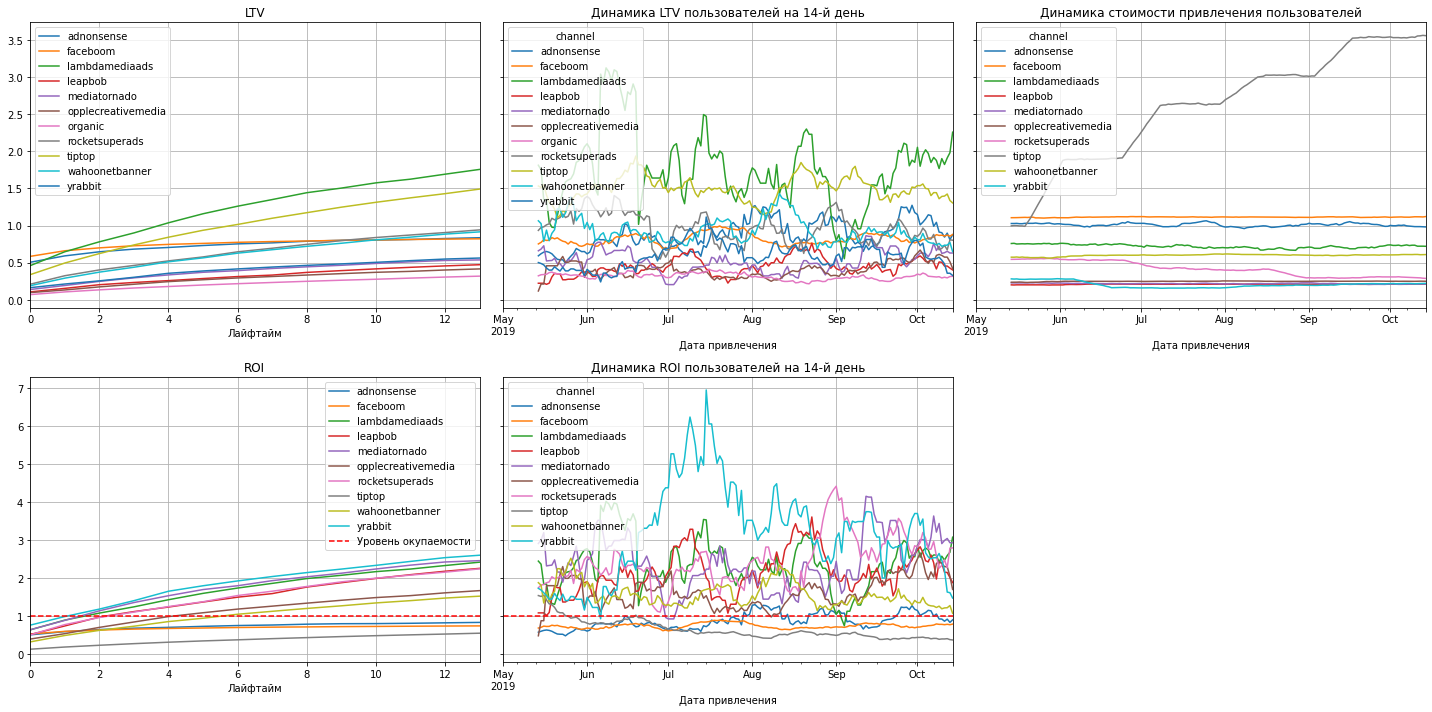

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

По графикам можно сделать следующие выводы:
- как видим из графика динамики САС канал tiptop съедает большую часть рекламного бюджета. Высокая стоимость привлечения не позволяет окупить вложенные средства, т.к LTV находится на сравнительно таком, как у других канлов уровне.
- По графику динамики ROI видно, что каналы tiptop, faceboom и adnonsense на протяжении всего временного периода не окупились на 14-й день жизни.
- Можно выделить наиболее перспективные каналы с точки зрения возврата инвестиций. Это каналы yrabbit и lambdamediaads. На протяжении всего временного интервала вложения в эти каналы окупались в несколько раз. Это произошло из-за сравнительно низкой стоимости привлечения и хорошем уровне LTV.

## Retention и конверсия  с разбивкой по устройствам, странам, рекламным каналам

* Удержание и конверсия с разбивкой по устройствам.

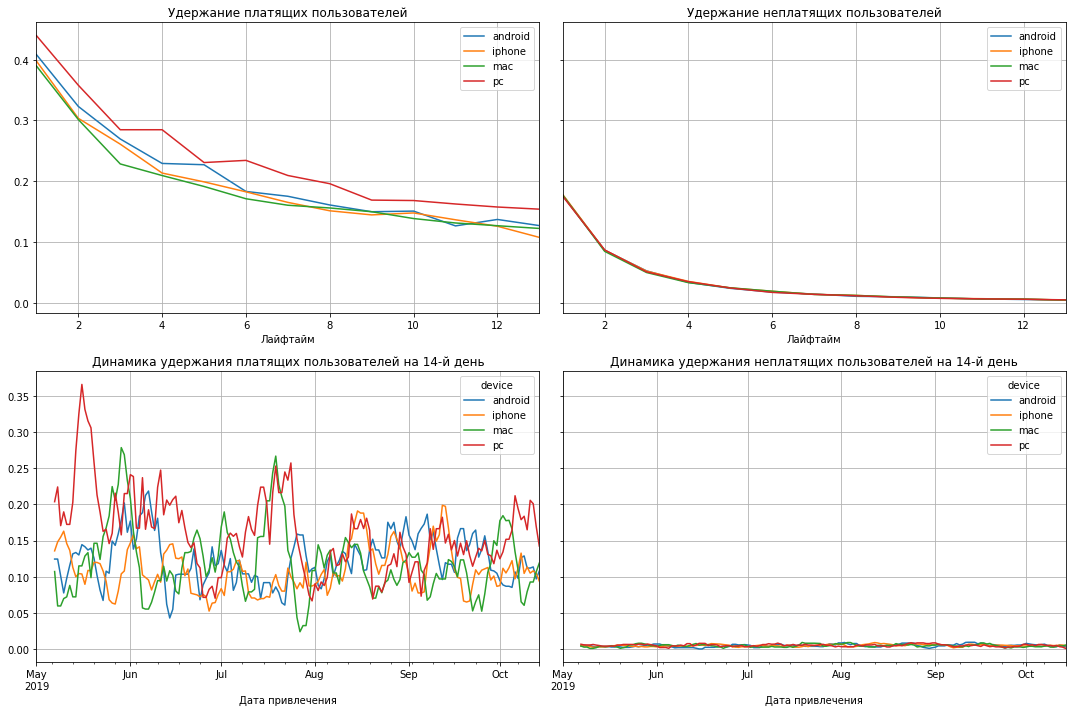

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days)

В целом каких-то аномалий не наблюдается. Можно заметить, что пользователи PC немногим лучше удерживаются.

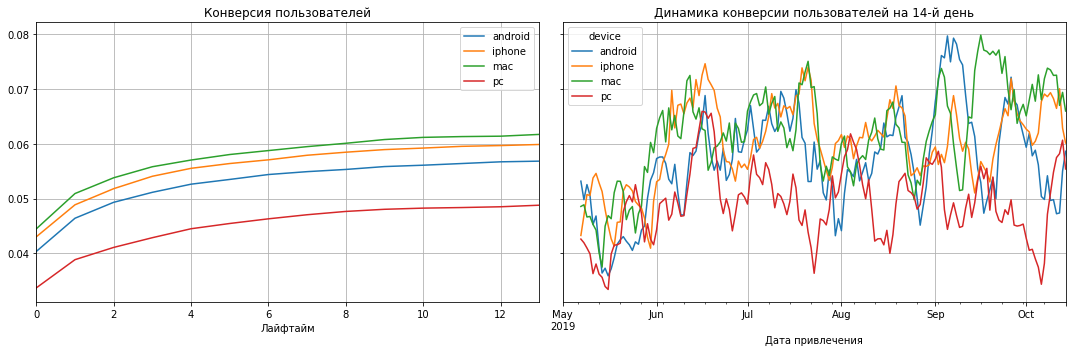

In [ ]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

А здесь картина противополжная удержанию. Конверсия пользователей PC находится на самом низком уровне. 

* Удержание и конверсия с разбивкой по странам.

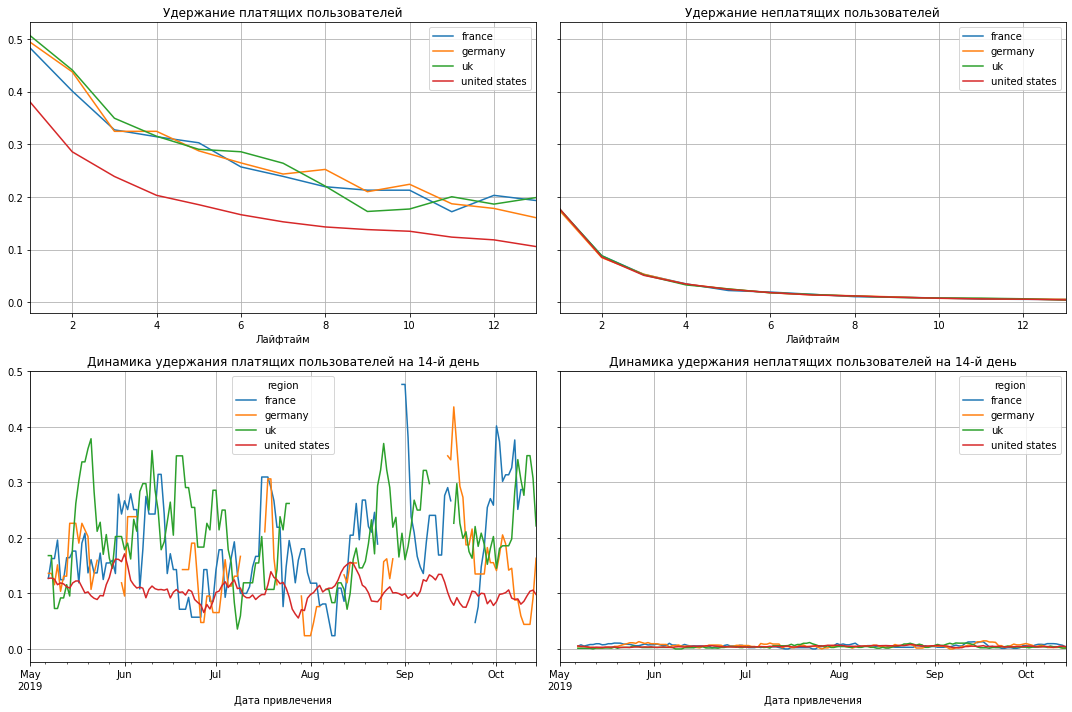

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days)

Вот еще одно подтверждение в пользу того, что нужно изменить регион привлечения пользователей. Практически весь бюджет брошен на США, а там самая высокая стоимость привлечения и самое низкое удержание пользователей. Это говорит о том, что большой отток пользователей будет вынуждать закупать еще рекламу, а реклама дорогая - юнит-экономика не сходится. Нужно менять стратегию маркетинга.

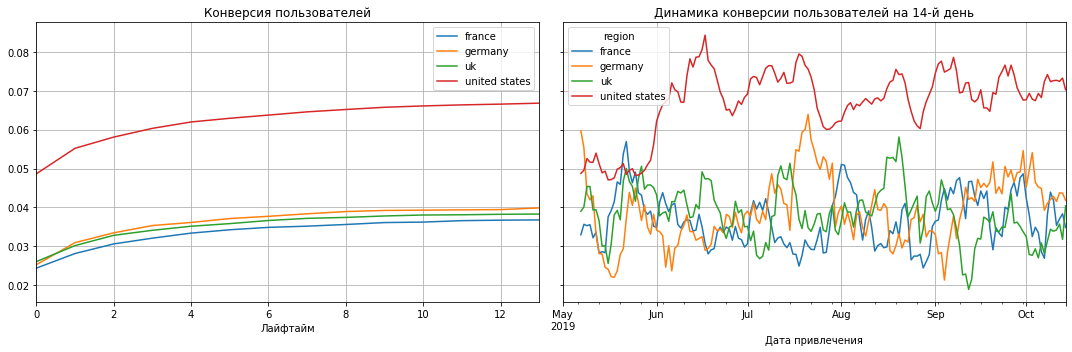

In [ ]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия в США самая высокая и превышает другие страны, но это и понятно - самый большой рынок, самый высокий ввп и платежеспособность населенияю Однако этому сопутствует и высокая конкуренция и как следствие огромная стоимость привлечения трафика и быстрое переключение пользователей с одного сервиса на другой, что подтверждает график удержания по странам.

* Удержание и конверсия с разбивкой по рекламным каналам.

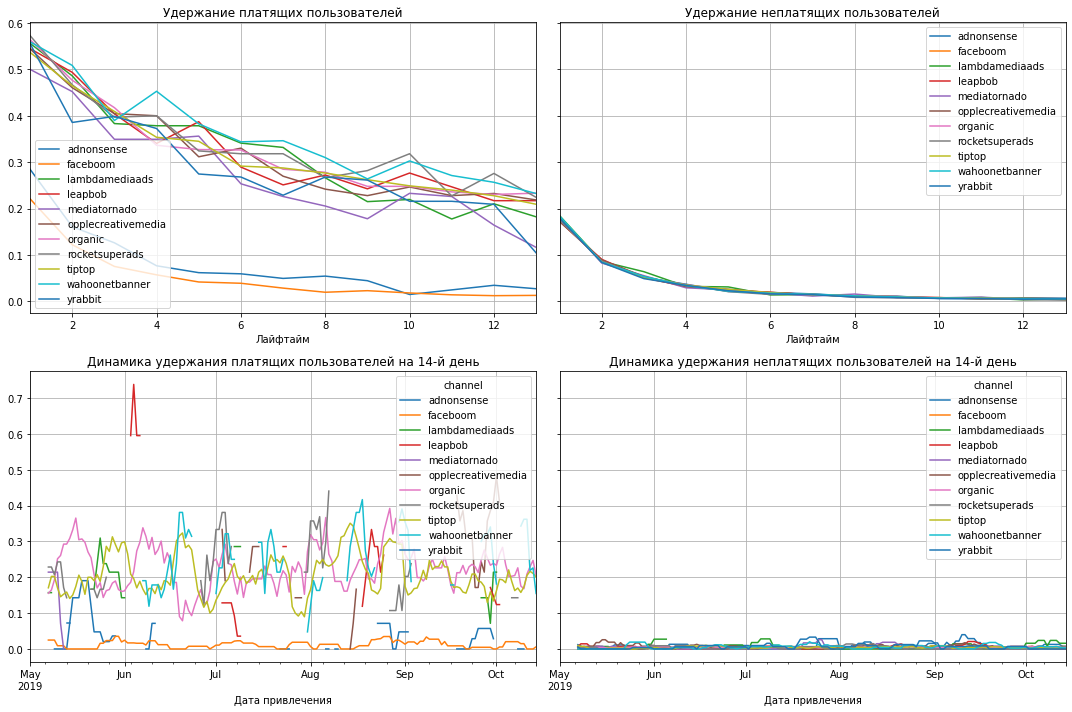

In [ ]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей из каналов faceboom и adnonsense самое низкое

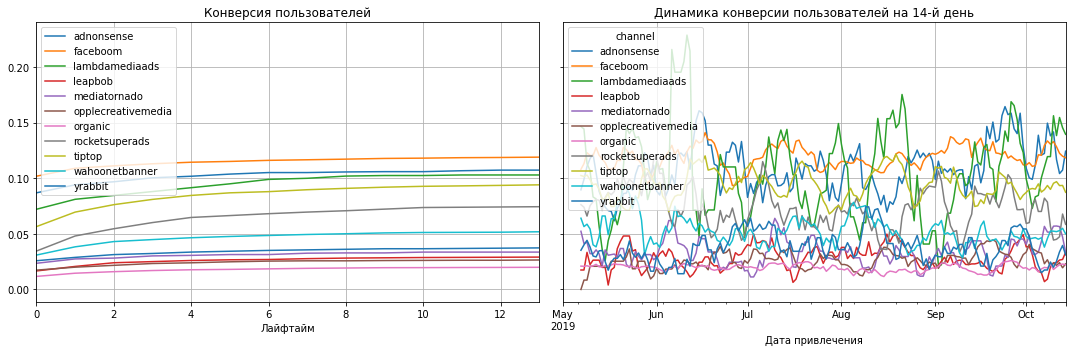

In [ ]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Из тех графиков, которые мы увидили можно явно сделать вывод о том, что рекламный бюджет расходовался преимущественно в США. Также было выявлено, что стоимость привлечения по всем каналам в США очень высокая в сравнении с другими странами. Исключать США из рекламных компаний довольно сложно, т.к это большой рынок и пользователи имеют горазду лучшую конверсию в покупку в сравнении с другими странами. Вероятно нужно оптимизировать распределение бюджета на рекламные площадки. Посмотрим более детально регион США и рекламные площадки. 

In [ ]:
profiles_usa = profiles.query('region == "united states" and channel != "organic"')

Сумма потраченная на рекламу в США

In [ ]:
profiles_usa['acquisition_cost'].sum()

90928.59999999999

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['channel']
)

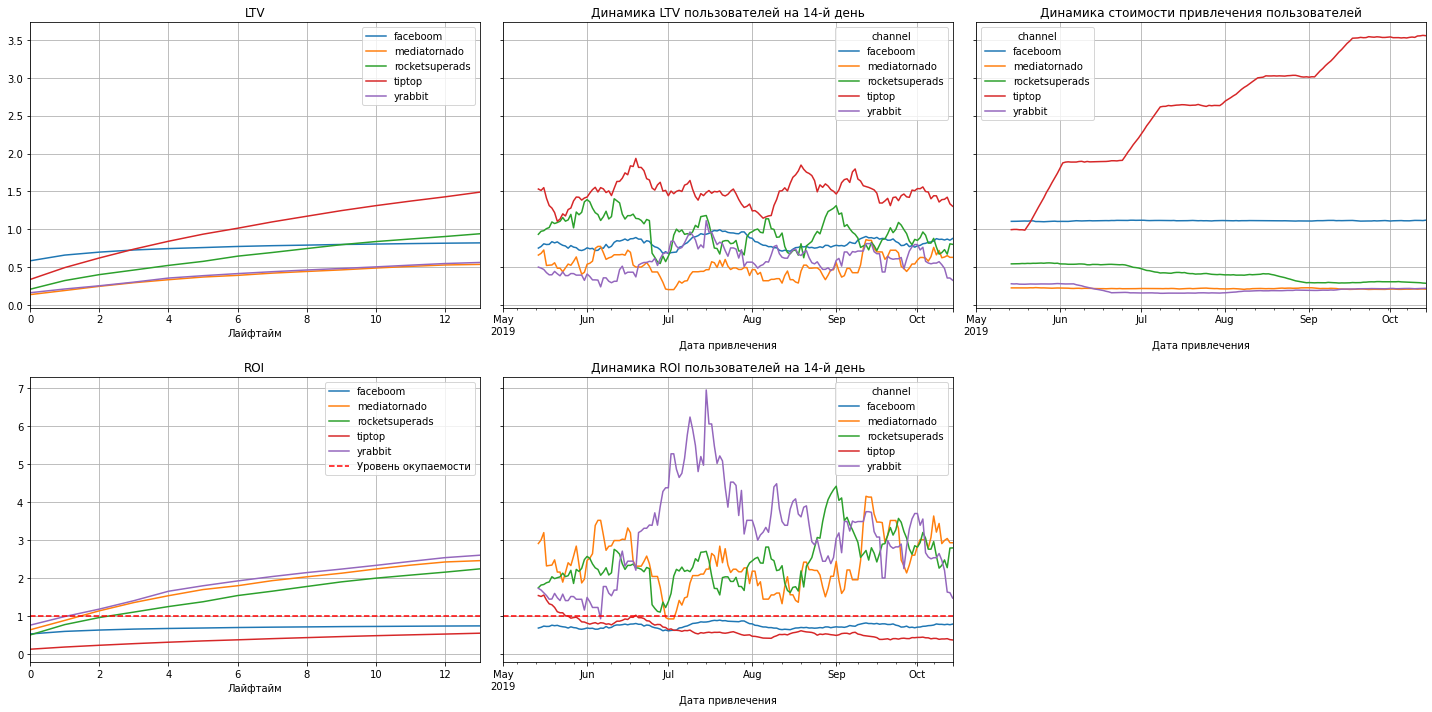

In [ ]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Теперь явно видно какие каналы не окупались в США - это tiptop и  faceboom. А именно на эти каналы было израсходовано больше всего денег.

# 5. Выводы и рекомендации


Целью аналитического проекта было вявить причину нефээфективной рекламной компании привлечения пользователей с 1 мая 2019 по 27 октября 2019. В результате анализа были сделаны следующие выводы:

1. Продуктовые метрики имеют неплохие показатели: количество пользователей в день, частота использования приложения, средняя длительность сессии, количество покупок на пользователя. Нет причин, позволяющих утверждать, что плохое качество продукта является главным признаком плохой окупаемости рекламы.
2. В общем на рекламу было потрачено 105 497. Общая выручка составила 215 963. Т.е доля рекламных расходов составила почти 50 %.
3. Рекламный бюджет был распределен между 11 площадками. На 2 площадки tiptop и faceboom пришлось 82% бюджета это 87 196.
4. Пользователи привлекались из 4-х стран на долю США пришлось 90 928 - это 86 % бюджета. Из них большая часть пришлась на 2 вышеупомянутых канала.
5. Именно эти 2 канала оказали отрицателное влияние на общий показатель ROI и как следствие на эффективность всей рекламной кампании. На графике динамики ROI пользователей на 14-й день по стране США видно, что только эти 2 канала привлечения находятся ниже уровня окупаемости.

### Рекомендации отделу маркетинга.

* Перераспределить реклманый бюджет. Исходя из вышеизложенных выводов стоит обратить внимание на другие рекламные площадки, где стоимость привлечения ниже, а LTV на сравнимом уровне. В США это все площаки, кроме tiptop и faceboom. В Европе это lamdamediaads. Эти площаки показывали хороший уровень ROI на протяжении всего рассматриваемого периода, что с большей вероятностью подтвердиться и в будущем.

* Отказываться от tiptop и faceboom не стоит. Возможно следует изменить стратегию рекламы на этих площадках и таким образом снизить CAC, а также ограничить бюджет. Следует отметить, что если платящие пользователи от tiptop показывали хороший уровень retention, то юзеры от faceboom имели сравнительно низкий уровень, что хорошо видно на графике удержания с разбивкой по каналам привлечения. Вероятно следует поменять креативы и привлекать другую аудиторию.